In [1]:
import torch

torch.cuda.empty_cache()

print("GPU available:", torch.cuda.is_available())

GPU available: True


## Visualization for Seizure data

In [12]:
import numpy as np
import scipy.io
import pandas as pd

# --- Load EEG Data ---
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s001_t000.mat")
data = mat['data'].T  # Full signal, shape: (time, 19 channels)
fs = int(mat['fs'].squeeze())  # Sampling frequency

# --- Optional: Load Label CSV if you need metadata ---
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
entry = ref_df[ref_df['filename'] == 'aaaaaaac_s001_t000'].iloc[0]
label = entry['label']  # seizure: 1, non-seizure: 0

# --- Use FULL Signal ---
segment = data  # Don't cut based on onset/offset

# --- Create 3 Bipolar Montages ---
montage1 = segment[:, 0] - segment[:, 1]
montage2 = segment[:, 1] - segment[:, 2]
montage3 = segment[:, 2] - segment[:, 3]

# --- Stack as (time, 3)
montages = np.stack([montage1, montage2, montage3], axis=1)

# --- Output ---
print(f"File: aaaaaaac_s001_t000  |  Seizure: {label}")
print("Full Montaged EEG shape:", montages.shape)


File: aaaaaaac_s001_t000  |  Seizure: 1
Full Montaged EEG shape: (75250, 3)


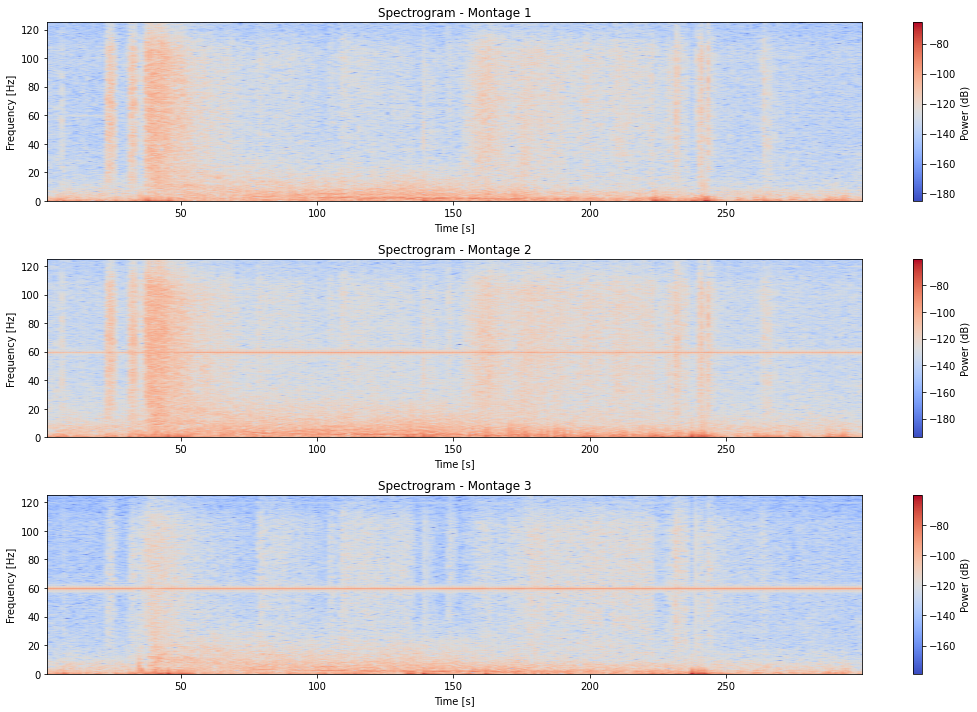

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# montages: shape (50081, 3)
channels = ['Montage 1', 'Montage 2', 'Montage 3']
fs = 250  # sampling frequency

plt.figure(figsize=(15, 10))

for i in range(3):
    f, t, Sxx = spectrogram(montages[:, i], fs=fs, nperseg=500, noverlap=200, nfft=1024)
    plt.subplot(3, 1, i + 1)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='coolwarm')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'Spectrogram - {channels[i]}')
    plt.colorbar(label='Power (dB)')

plt.tight_layout()
plt.show()


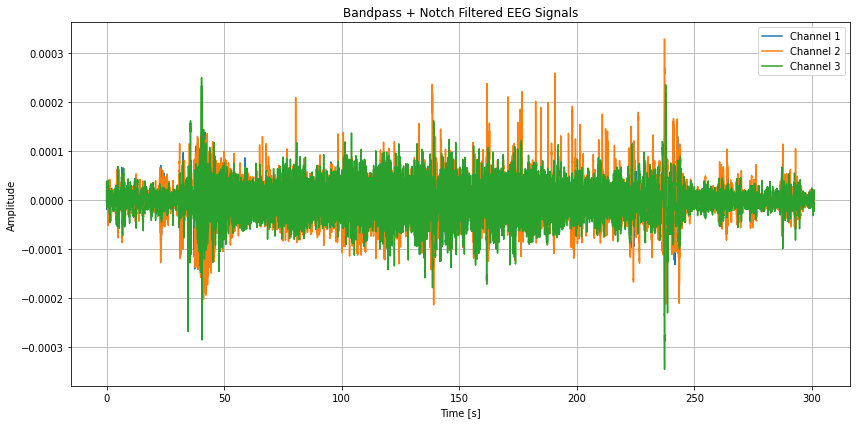

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

# --- Filter Settings ---
fs = 250  # sampling frequency
lowcut = 0.5
highcut = 70.0
notch_freq = 60.0
quality_factor = 35.0

# --- Bandpass Filter (Butterworth) ---
b_bp, a_bp = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)

# --- Notch Filter at 50 Hz ---
b_notch, a_notch = iirnotch(w0=notch_freq, Q=quality_factor, fs=fs)

# --- Apply Filters to Each Channel ---
filtered = np.zeros_like(montages)
for i in range(3):
    signal = montages[:, i]
    signal = filtfilt(b_bp, a_bp, signal)
    signal = filtfilt(b_notch, a_notch, signal)
    filtered[:, i] = signal

# --- Time Axis ---
t = np.arange(filtered.shape[0]) / fs

# --- Plot Filtered Signals ---
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(t, filtered[:, i], label=f'Channel {i+1}')
plt.title('Bandpass + Notch Filtered EEG Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


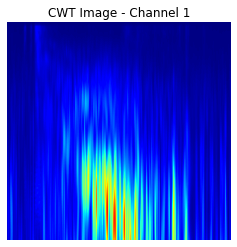

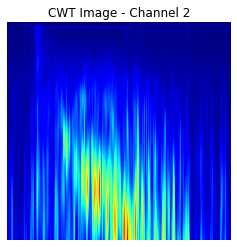

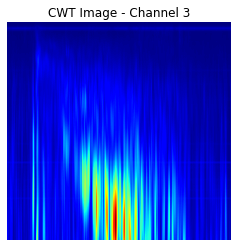

Original CWT shape for Channel 1: (128, 75250)
Resized image shape: (227, 227)
Original CWT shape for Channel 2: (128, 75250)
Resized image shape: (227, 227)
Original CWT shape for Channel 3: (128, 75250)
Resized image shape: (227, 227)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage.transform import resize


wavelet = 'cmor1.5-1.0'  # complex Morlet similar to MATLAB's 'amor'
scales = np.arange(1, 129)
target_size = (227, 227)

# Function to compute CWT image from a signal
def compute_cwt_image(signal, fs=250, scales=scales, wavelet=wavelet, target_size=(227, 227)):
    coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)
    cwt_abs = np.abs(coefficients)
    cwt_log = np.log1p(cwt_abs)  # add 1 to avoid log(0)
    
    # Normalize to [0, 1]
    cwt_norm = (cwt_log - np.min(cwt_log)) / (np.max(cwt_log) - np.min(cwt_log))
    
    # Resize for CNN input
    resized = resize(cwt_norm, target_size, mode='reflect', anti_aliasing=True)
    
    return resized, cwt_norm.shape

# Apply to all 3 channels
cwt_images = []
original_shapes = []

for i in range(3):
    cwt_img, original_shape = compute_cwt_image(montages[:, i])
    cwt_images.append(cwt_img)
    original_shapes.append(original_shape)
    
    # Show the image
    plt.figure(figsize=(4, 4))
    plt.imshow(cwt_img, cmap='jet', aspect='auto')
    plt.title(f'CWT Image - Channel {i+1}')
    plt.axis('off')
    plt.show()

# Display image data sizes
for i, shape in enumerate(original_shapes):
    print(f"Original CWT shape for Channel {i+1}: {shape}")
    print(f"Resized image shape: {cwt_images[i].shape}")


## Visualization for Non-seizure data

In [2]:
import numpy as np
import scipy.io
import pandas as pd

# --- Load EEG Data ---
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s004_t002.mat")
data = mat['data'].T  # Full signal, shape: (time, 19 channels)
fs = int(mat['fs'].squeeze())  # Sampling frequency

# --- Optional: Load Label CSV if you need metadata ---
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
entry = ref_df[ref_df['filename'] == 'aaaaaaac_s004_t002'].iloc[0]
label = entry['label']  # seizure: 1, non-seizure: 0

# --- Use FULL Signal ---
segment = data  # Don't cut based on onset/offset

# --- Create 3 Bipolar Montages ---
montage1 = segment[:, 0] - segment[:, 1]
montage2 = segment[:, 1] - segment[:, 2]
montage3 = segment[:, 2] - segment[:, 3]

# --- Stack as (time, 3)
montages = np.stack([montage1, montage2, montage3], axis=1)

# --- Output ---
print(f"File: aaaaaaac_s001_t000  |  Seizure: {label}")
print("Full Montaged EEG shape:", montages.shape)


File: aaaaaaac_s001_t000  |  Seizure: 0
Full Montaged EEG shape: (156500, 3)


In [24]:
import numpy as np
import scipy.io
import pandas as pd
from wettbewerb import get_3montages  

# --- Load EEG Data ---
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s001_t000.mat")
data = mat['data']  # shape: (channels, time)
fs = int(mat['fs'].squeeze())

# ✅ Fix channel names (strip spaces)
channels = [ch.strip() for ch in mat['channels']]

# --- Load label info ---
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
entry = ref_df[ref_df['filename'] == 'aaaaaaac_s001_t000'].iloc[0]
label = entry['label']

# --- Get 3 bipolar montages ---
montage_names, montage_data, missing = get_3montages(channels, data)

if missing:
    print(" Warning: One or more montage channels are missing.")
    for ch1, ch2 in [('Fp1', 'F3'), ('Fp2', 'F4'), ('C3', 'P3')]:
        if ch1 not in channels or ch2 not in channels:
            print(f" Missing: {ch1}-{ch2}")
else:
    print("✅ All montage channels found.")

# Transpose to shape (time, 3)
montages = montage_data.T

# --- Output ---
print(f"File: aaaaaaac_s004_t002  |  Seizure: {label}")
print("Montaged EEG shape:", montages.shape)


✅ All montage channels found.
File: aaaaaaac_s004_t002  |  Seizure: 1
Montaged EEG shape: (75250, 3)


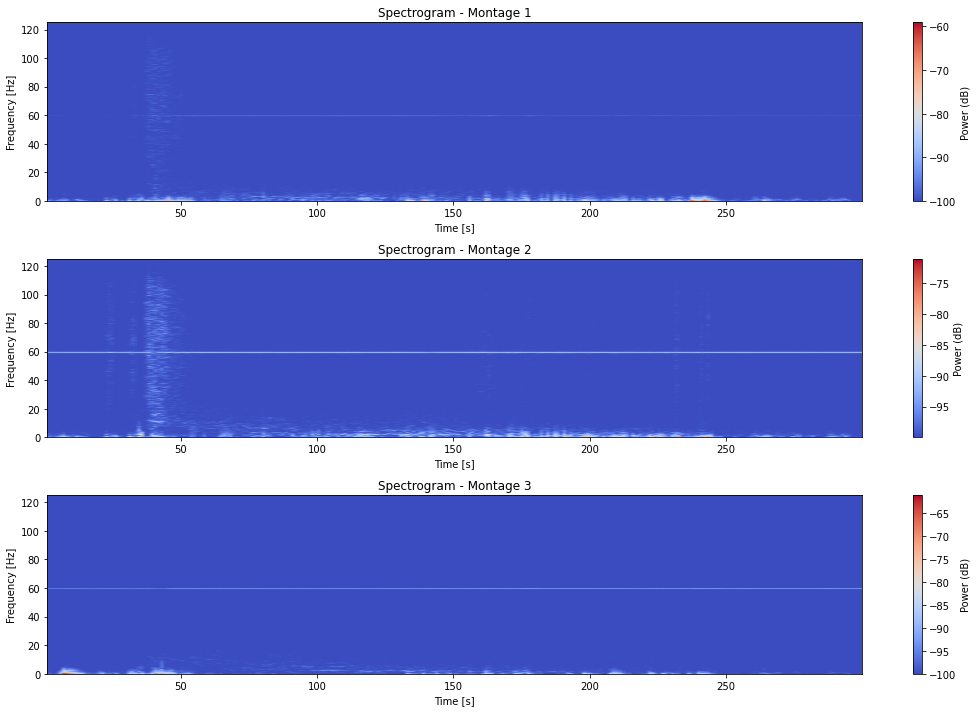

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

channels = ['Montage 1', 'Montage 2', 'Montage 3']
fs = 250  # sampling frequency

plt.figure(figsize=(15, 10))

for i in range(3):
    f, t, Sxx = spectrogram(montages[:, i], fs=fs, nperseg=500, noverlap=200, nfft=1024)
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Avoid log10(0)
    plt.subplot(3, 1, i + 1)
    plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='coolwarm')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'Spectrogram - {channels[i]}')
    plt.colorbar(label='Power (dB)')

plt.tight_layout()
plt.show()


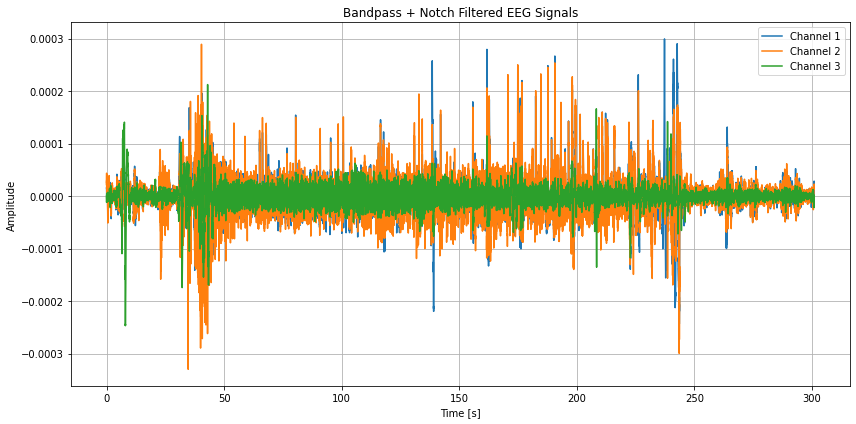

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch

# --- Filter Settings ---
fs = 250  # sampling frequency
lowcut = 0.5
highcut = 70.0
notch_freq = 60.0
quality_factor = 35.0

# --- Bandpass Filter (Butterworth) ---
b_bp, a_bp = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)

# --- Notch Filter at 50 Hz ---
b_notch, a_notch = iirnotch(w0=notch_freq, Q=quality_factor, fs=fs)

# --- Apply Filters to Each Channel ---
filtered = np.zeros_like(montages)
for i in range(3):
    signal = montages[:, i]
    signal = filtfilt(b_bp, a_bp, signal)
    signal = filtfilt(b_notch, a_notch, signal)
    filtered[:, i] = signal

# --- Time Axis ---
t = np.arange(filtered.shape[0]) / fs

# --- Plot Filtered Signals ---
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(t, filtered[:, i], label=f'Channel {i+1}')
plt.title('Bandpass + Notch Filtered EEG Signals')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


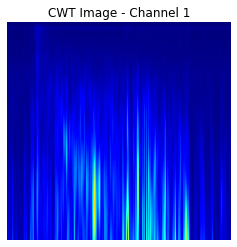

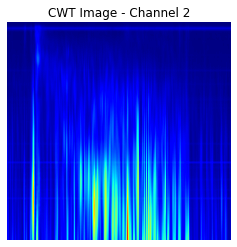

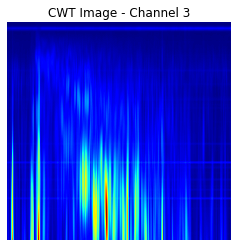

Original CWT shape for Channel 1: (128, 75250)
Resized image shape: (227, 227)
Original CWT shape for Channel 2: (128, 75250)
Resized image shape: (227, 227)
Original CWT shape for Channel 3: (128, 75250)
Resized image shape: (227, 227)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage.transform import resize


wavelet = 'cmor1.5-1.0'  # complex Morlet similar to MATLAB's 'amor'
scales = np.arange(1, 129)
target_size = (227, 227)

# Function to compute CWT image from a signal
def compute_cwt_image(signal, fs=250, scales=scales, wavelet=wavelet, target_size=(227, 227)):
    coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)
    cwt_abs = np.abs(coefficients)
    cwt_log = np.log1p(cwt_abs)  # add 1 to avoid log(0)
    
    # Normalize to [0, 1]
    cwt_norm = (cwt_log - np.min(cwt_log)) / (np.max(cwt_log) - np.min(cwt_log))
    
    # Resize for CNN input
    resized = resize(cwt_norm, target_size, mode='reflect', anti_aliasing=True)
    
    return resized, cwt_norm.shape

# Apply to all 3 channels
cwt_images = []
original_shapes = []

for i in range(3):
    cwt_img, original_shape = compute_cwt_image(montages[:, i])
    cwt_images.append(cwt_img)
    original_shapes.append(original_shape)
    
    # Show the image
    plt.figure(figsize=(4, 4))
    plt.imshow(cwt_img, cmap='jet', aspect='auto')
    plt.title(f'CWT Image - Channel {i+1}')
    plt.axis('off')
    plt.show()

# Display image data sizes
for i, shape in enumerate(original_shapes):
    print(f"Original CWT shape for Channel {i+1}: {shape}")
    print(f"Resized image shape: {cwt_images[i].shape}")


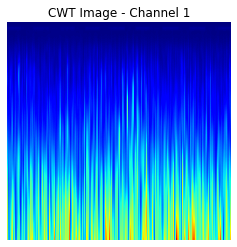

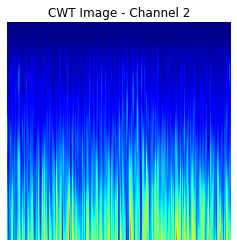

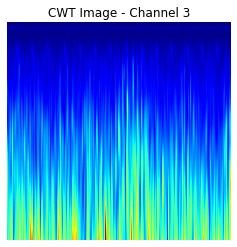

Original CWT shape for Channel 1: (128, 156500)
Resized image shape: (256, 256)
Original CWT shape for Channel 2: (128, 156500)
Resized image shape: (256, 256)
Original CWT shape for Channel 3: (128, 156500)
Resized image shape: (256, 256)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage.transform import resize


wavelet = 'cmor1.5-1.0'  # complex Morlet similar to MATLAB's 'amor'
scales = np.arange(1, 129)
target_size = (256, 256)

# Function to compute CWT image from a signal
def compute_cwt_image(signal, fs=250, scales=scales, wavelet=wavelet, target_size=(256, 256)):
    coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)
    cwt_abs = np.abs(coefficients)
    cwt_log = np.log1p(cwt_abs)  # add 1 to avoid log(0)
    
    # Normalize to [0, 1]
    cwt_norm = (cwt_log - np.min(cwt_log)) / (np.max(cwt_log) - np.min(cwt_log))
    
    # Resize for CNN input
    resized = resize(cwt_norm, target_size, mode='reflect', anti_aliasing=True)
    
    return resized, cwt_norm.shape

# Apply to all 3 channels
cwt_images = []
original_shapes = []

for i in range(3):
    cwt_img, original_shape = compute_cwt_image(montages[:, i])
    cwt_images.append(cwt_img)
    original_shapes.append(original_shape)
    
    # Show the image
    plt.figure(figsize=(4, 4))
    plt.imshow(cwt_img, cmap='jet', aspect='auto')
    plt.title(f'CWT Image - Channel {i+1}')
    plt.axis('off')
    plt.show()

# Display image data sizes
for i, shape in enumerate(original_shapes):
    print(f"Original CWT shape for Channel {i+1}: {shape}")
    print(f"Resized image shape: {cwt_images[i].shape}")


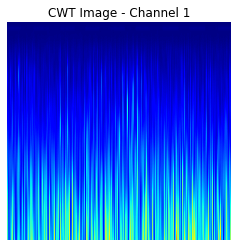

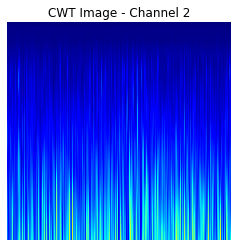

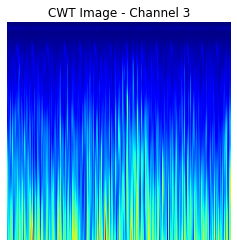

Original CWT shape for Channel 1: (128, 156500)
Resized image shape: (512, 512)
Original CWT shape for Channel 2: (128, 156500)
Resized image shape: (512, 512)
Original CWT shape for Channel 3: (128, 156500)
Resized image shape: (512, 512)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage.transform import resize


wavelet = 'cmor1.5-1.0'  # complex Morlet similar to MATLAB's 'amor'
scales = np.arange(1, 129)
target_size = (512, 512)

# Function to compute CWT image from a signal
def compute_cwt_image(signal, fs=250, scales=scales, wavelet=wavelet, target_size=(512, 512)):
    coefficients, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/fs)
    cwt_abs = np.abs(coefficients)
    cwt_log = np.log1p(cwt_abs)  # add 1 to avoid log(0)
    
    # Normalize to [0, 1]
    cwt_norm = (cwt_log - np.min(cwt_log)) / (np.max(cwt_log) - np.min(cwt_log))
    
    # Resize for CNN input
    resized = resize(cwt_norm, target_size, mode='reflect', anti_aliasing=True)
    
    return resized, cwt_norm.shape

# Apply to all 3 channels
cwt_images = []
original_shapes = []

for i in range(3):
    cwt_img, original_shape = compute_cwt_image(montages[:, i])
    cwt_images.append(cwt_img)
    original_shapes.append(original_shape)
    
    # Show the image
    plt.figure(figsize=(4, 4))
    plt.imshow(cwt_img, cmap='jet', aspect='auto')
    plt.title(f'CWT Image - Channel {i+1}')
    plt.axis('off')
    plt.show()

# Display image data sizes
for i, shape in enumerate(original_shapes):
    print(f"Original CWT shape for Channel {i+1}: {shape}")
    print(f"Resized image shape: {cwt_images[i].shape}")


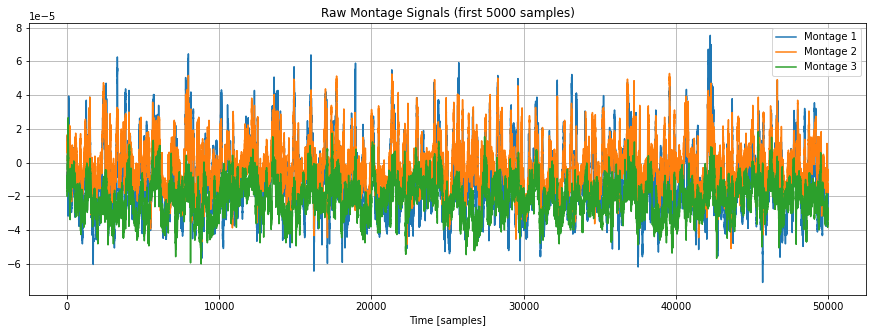

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i in range(3):
    plt.plot(montages[:50000, i], label=f'Montage {i+1}')
plt.title("Raw Montage Signals (first 5000 samples)")
plt.xlabel("Time [samples]")
plt.legend()
plt.grid(True)
plt.show()


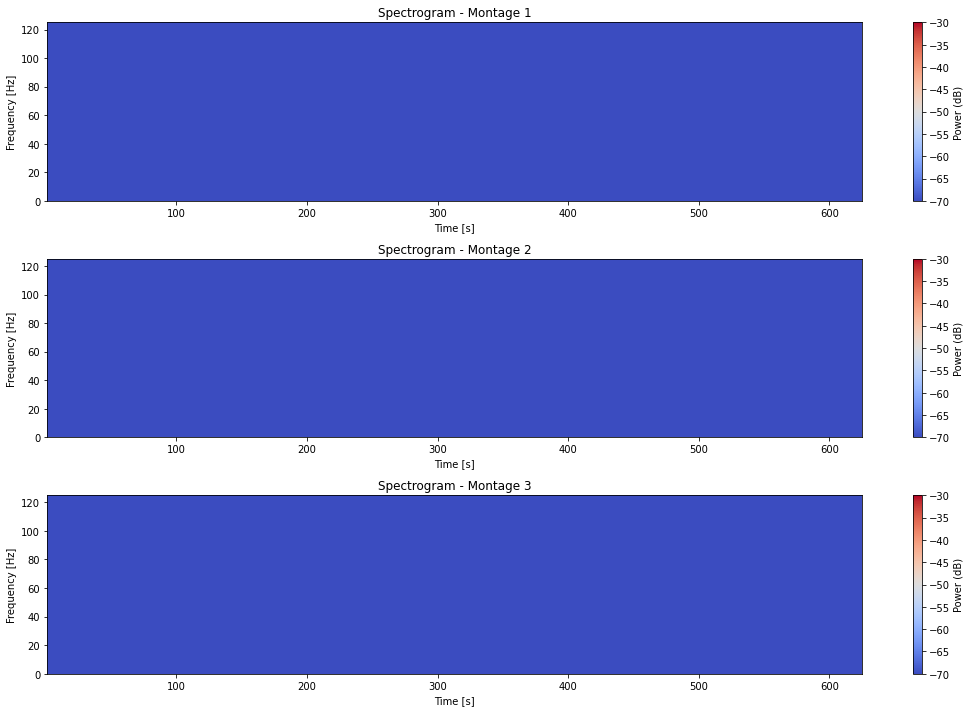

In [23]:
# --- Plot spectrograms with adjusted dB scale
channel_labels = ['Montage 1', 'Montage 2', 'Montage 3']
plt.figure(figsize=(15, 10))

for i in range(3):
    f, t, Sxx = spectrogram(montages[:, i], fs=fs, nperseg=500, noverlap=200, nfft=1024)
    Sxx_dB = 10 * np.log10(Sxx + 1e-10)  # Avoid log10(0)

    plt.subplot(3, 1, i + 1)
    plt.pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap='coolwarm', vmin=-70, vmax=-30)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    plt.title(f'Spectrogram - {channel_labels[i]}')
    plt.colorbar(label='Power (dB)')

plt.tight_layout()
plt.show()

1


/home/jupyter-wki_team_1/ipykernel_177889/3271539472.py:33: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()
/opt/tljh/user/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


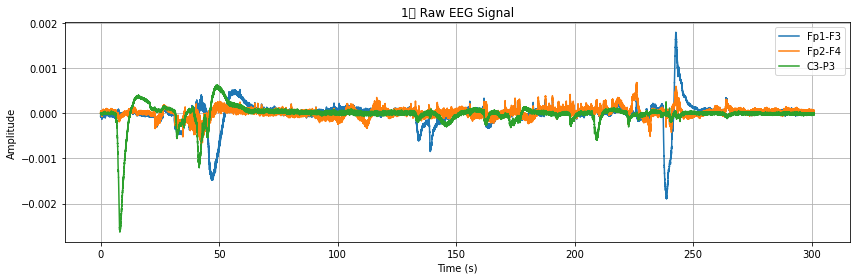

/home/jupyter-wki_team_1/ipykernel_177889/3271539472.py:51: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()
/opt/tljh/user/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


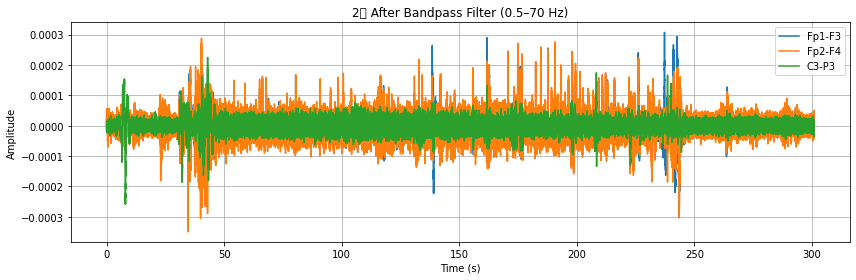

/home/jupyter-wki_team_1/ipykernel_177889/3271539472.py:69: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()
/opt/tljh/user/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


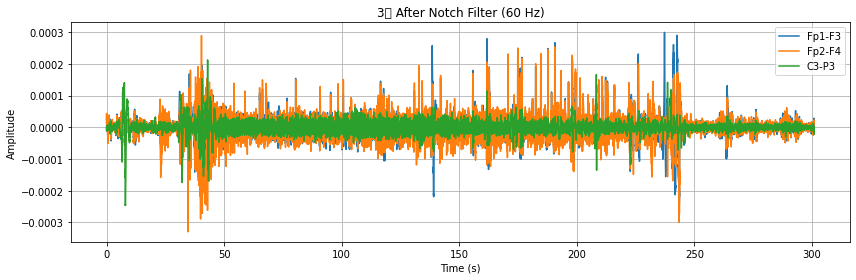

/home/jupyter-wki_team_1/ipykernel_177889/3271539472.py:109: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()


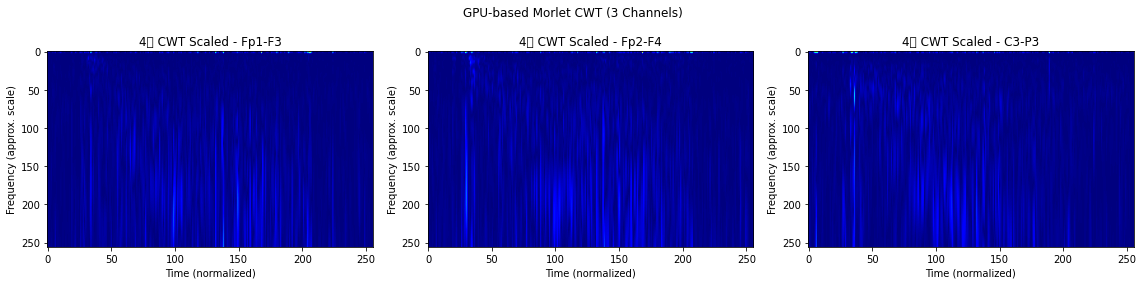

In [33]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.signal import butter, filtfilt, iirnotch
from wettbewerb import get_3montages

# --- Load EEG ---
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s001_t000.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s001_t000'].iloc[0]['label']
print(label)
# --- Get 3 bipolar montages ---
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T  # shape: (time, 3)
t = np.arange(montages.shape[0]) / fs

# --- 1️⃣ Visualize Raw EEG ---
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(t, montages[:, i], label=montage_names[i])
plt.title("1️⃣ Raw EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2️⃣ Bandpass Filter (0.5–70 Hz) ---
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

filtered_bp = bandpass_filter(montages, fs)

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(t, filtered_bp[:, i], label=montage_names[i])
plt.title("2️⃣ After Bandpass Filter (0.5–70 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3️⃣ Notch Filter (60 Hz) ---
def notch_filter(signal, fs, freq=60.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered_notch = notch_filter(filtered_bp, fs)

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(t, filtered_notch[:, i], label=montage_names[i])
plt.title("3️⃣ After Notch Filter (60 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4️⃣ GPU-based Morlet Convolution (CWT Equivalent) ---
def morlet_conv_torch(signal_np, fs, scales, target_size=(256, 256), device='cuda'):
    signal = torch.tensor(signal_np.T.copy(), dtype=torch.float32, device=device)  # (3, T)
    time = torch.arange(signal.shape[1], device=device) / fs
    time = time - time.mean()
    results = []

    for ch in range(signal.shape[0]):
        scalogram = []
        for scale in scales:
            sigma = scale / fs
            wavelet = torch.exp(-time**2 / (2 * sigma**2)) * torch.cos(2 * np.pi * fs / scale * time)
            wavelet = wavelet / wavelet.abs().sum()
            kernel = wavelet.view(1, 1, -1)
            sig = signal[ch].view(1, 1, -1)
            conv = F.conv1d(sig, kernel, padding='same')
            conv = torch.abs(conv.squeeze())
            scalogram.append(conv)
        scalogram = torch.stack(scalogram)  # (scales, T)
        log_scaled = torch.log1p(scalogram)
        norm = (log_scaled - log_scaled.min()) / (log_scaled.max() - log_scaled.min() + 1e-6)
        resized = F.interpolate(norm.unsqueeze(0).unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)
        results.append(resized.squeeze().cpu().numpy())
    return np.stack(results)  # shape: (3, H, W)

# Scales and GPU conversion
scales = torch.arange(1, 129, device='cuda')
cwt_output = morlet_conv_torch(filtered_notch, fs, scales)

# --- 5️⃣ Visualize CWT Outputs ---
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    axs[i].imshow(cwt_output[i], aspect='auto', cmap='jet', origin='upper')
    axs[i].set_title(f"4️⃣ CWT Scaled - {montage_names[i]}")
    axs[i].set_ylabel("Frequency (approx. scale)")
    axs[i].set_xlabel("Time (normalized)")
plt.suptitle("GPU-based Morlet CWT (3 Channels)")
plt.tight_layout()
plt.show()


0


/home/jupyter-wki_team_1/ipykernel_177889/3238836785.py:33: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()
/opt/tljh/user/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


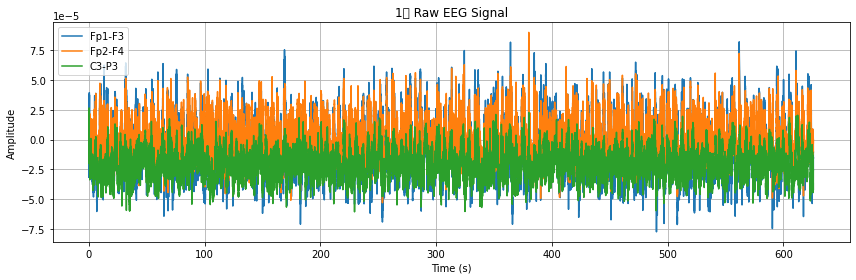

/home/jupyter-wki_team_1/ipykernel_177889/3238836785.py:51: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()
/opt/tljh/user/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


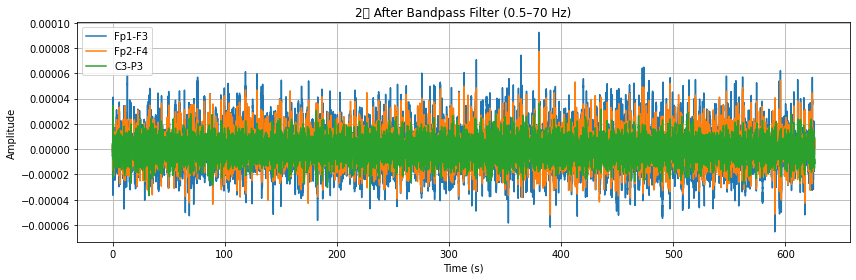

/home/jupyter-wki_team_1/ipykernel_177889/3238836785.py:69: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()
/opt/tljh/user/envs/pytorch/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


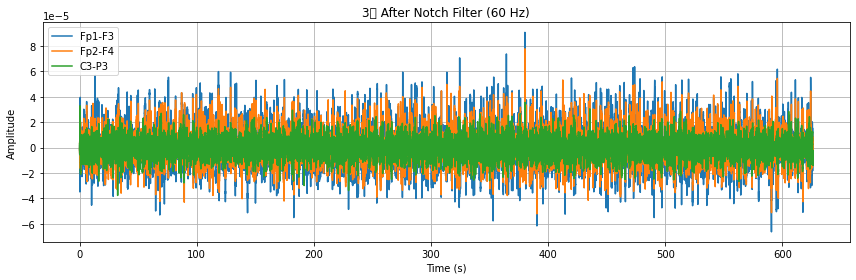

/home/jupyter-wki_team_1/ipykernel_177889/3238836785.py:109: UserWarning: Glyph 8419 (\N{COMBINING ENCLOSING KEYCAP}) missing from current font.
  plt.tight_layout()


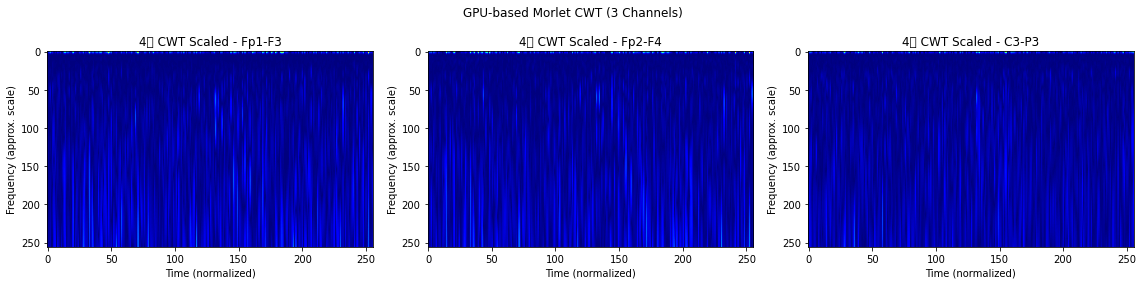

In [32]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.signal import butter, filtfilt, iirnotch
from wettbewerb import get_3montages

# --- Load EEG ---
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s004_t002.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s004_t002'].iloc[0]['label']
print(label)
# --- Get 3 bipolar montages ---
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T  # shape: (time, 3)
t = np.arange(montages.shape[0]) / fs

# --- 1️⃣ Visualize Raw EEG ---
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(t, montages[:, i], label=montage_names[i])
plt.title("1️⃣ Raw EEG Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 2️⃣ Bandpass Filter (0.5–70 Hz) ---
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

filtered_bp = bandpass_filter(montages, fs)

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(t, filtered_bp[:, i], label=montage_names[i])
plt.title("2️⃣ After Bandpass Filter (0.5–70 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 3️⃣ Notch Filter (60 Hz) ---
def notch_filter(signal, fs, freq=60.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered_notch = notch_filter(filtered_bp, fs)

plt.figure(figsize=(12, 4))
for i in range(3):
    plt.plot(t, filtered_notch[:, i], label=montage_names[i])
plt.title("3️⃣ After Notch Filter (60 Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 4️⃣ GPU-based Morlet Convolution (CWT Equivalent) ---
def morlet_conv_torch(signal_np, fs, scales, target_size=(256, 256), device='cuda'):
    signal = torch.tensor(signal_np.T.copy(), dtype=torch.float32, device=device)  # (3, T)
    time = torch.arange(signal.shape[1], device=device) / fs
    time = time - time.mean()
    results = []

    for ch in range(signal.shape[0]):
        scalogram = []
        for scale in scales:
            sigma = scale / fs
            wavelet = torch.exp(-time**2 / (2 * sigma**2)) * torch.cos(2 * np.pi * fs / scale * time)
            wavelet = wavelet / wavelet.abs().sum()
            kernel = wavelet.view(1, 1, -1)
            sig = signal[ch].view(1, 1, -1)
            conv = F.conv1d(sig, kernel, padding='same')
            conv = torch.abs(conv.squeeze())
            scalogram.append(conv)
        scalogram = torch.stack(scalogram)  # (scales, T)
        log_scaled = torch.log1p(scalogram)
        norm = (log_scaled - log_scaled.min()) / (log_scaled.max() - log_scaled.min() + 1e-6)
        resized = F.interpolate(norm.unsqueeze(0).unsqueeze(0), size=target_size, mode='bilinear', align_corners=False)
        results.append(resized.squeeze().cpu().numpy())
    return np.stack(results)  # shape: (3, H, W)

# Scales and GPU conversion
scales = torch.arange(1, 129, device='cuda')
cwt_output = morlet_conv_torch(filtered_notch, fs, scales)

# --- 5️⃣ Visualize CWT Outputs ---
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    axs[i].imshow(cwt_output[i], aspect='auto', cmap='jet', origin='upper')
    axs[i].set_title(f"4️⃣ CWT Scaled - {montage_names[i]}")
    axs[i].set_ylabel("Frequency (approx. scale)")
    axs[i].set_xlabel("Time (normalized)")
plt.suptitle("GPU-based Morlet CWT (3 Channels)")
plt.tight_layout()
plt.show()


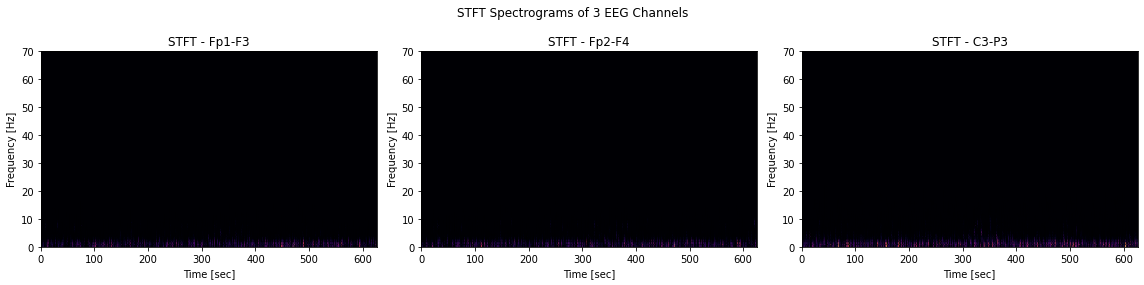

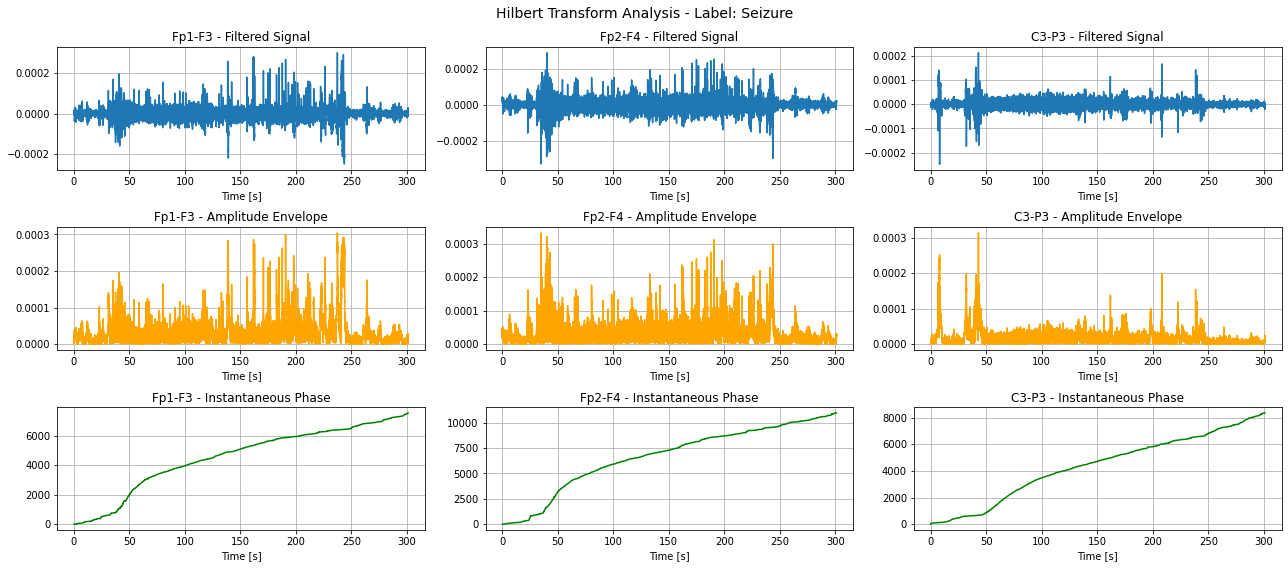

In [36]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, hilbert
from wettbewerb import get_3montages

# ========== Load EEG ==========
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s001_t000.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s001_t000'].iloc[0]['label']

# ========== Get 3 Bipolar Montages ==========
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T
time = np.arange(montages.shape[0]) / fs

# ========== Filters ==========
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, fs, freq=60.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered = bandpass_filter(montages, fs)
filtered = notch_filter(filtered, fs)

# ========== Hilbert Transform ==========
analytic = hilbert(filtered, axis=0)
amplitude_envelope = np.abs(analytic)
instantaneous_phase = np.unwrap(np.angle(analytic), axis=0)

# ========== Plotting ==========
fig, axs = plt.subplots(3, 3, figsize=(18, 8))
for i in range(3):
    axs[0, i].plot(time, filtered[:, i], label='Filtered Signal')
    axs[0, i].set_title(f"{montage_names[i]} - Filtered Signal")
    axs[0, i].set_xlabel("Time [s]")
    axs[0, i].grid()

    axs[1, i].plot(time, amplitude_envelope[:, i], color='orange', label='Amplitude Envelope')
    axs[1, i].set_title(f"{montage_names[i]} - Amplitude Envelope")
    axs[1, i].set_xlabel("Time [s]")
    axs[1, i].grid()

    axs[2, i].plot(time, instantaneous_phase[:, i], color='green', label='Instantaneous Phase')
    axs[2, i].set_title(f"{montage_names[i]} - Instantaneous Phase")
    axs[2, i].set_xlabel("Time [s]")
    axs[2, i].grid()

plt.suptitle(f"Hilbert Transform Analysis - Label: {'Seizure' if label==1 else 'Non-Seizure'}", fontsize=14)
plt.tight_layout()
plt.show()


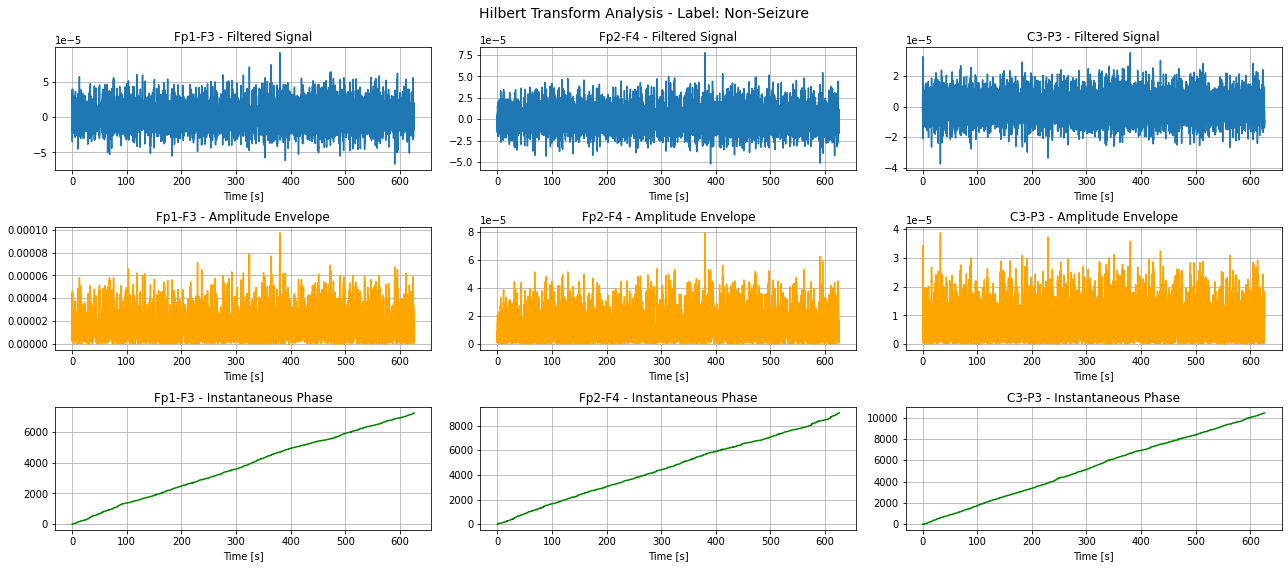

In [37]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, hilbert
from wettbewerb import get_3montages

# ========== Load EEG ==========
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s004_t002.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s004_t002'].iloc[0]['label']

# ========== Get 3 Bipolar Montages ==========
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T
time = np.arange(montages.shape[0]) / fs

# ========== Filters ==========
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, fs, freq=60.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered = bandpass_filter(montages, fs)
filtered = notch_filter(filtered, fs)

# ========== Hilbert Transform ==========
analytic = hilbert(filtered, axis=0)
amplitude_envelope = np.abs(analytic)
instantaneous_phase = np.unwrap(np.angle(analytic), axis=0)

# ========== Plotting ==========
fig, axs = plt.subplots(3, 3, figsize=(18, 8))
for i in range(3):
    axs[0, i].plot(time, filtered[:, i], label='Filtered Signal')
    axs[0, i].set_title(f"{montage_names[i]} - Filtered Signal")
    axs[0, i].set_xlabel("Time [s]")
    axs[0, i].grid()

    axs[1, i].plot(time, amplitude_envelope[:, i], color='orange', label='Amplitude Envelope')
    axs[1, i].set_title(f"{montage_names[i]} - Amplitude Envelope")
    axs[1, i].set_xlabel("Time [s]")
    axs[1, i].grid()

    axs[2, i].plot(time, instantaneous_phase[:, i], color='green', label='Instantaneous Phase')
    axs[2, i].set_title(f"{montage_names[i]} - Instantaneous Phase")
    axs[2, i].set_xlabel("Time [s]")
    axs[2, i].grid()

plt.suptitle(f"Hilbert Transform Analysis - Label: {'Seizure' if label==1 else 'Non-Seizure'}", fontsize=14)
plt.tight_layout()
plt.show()


Feature vector shape: (210,)


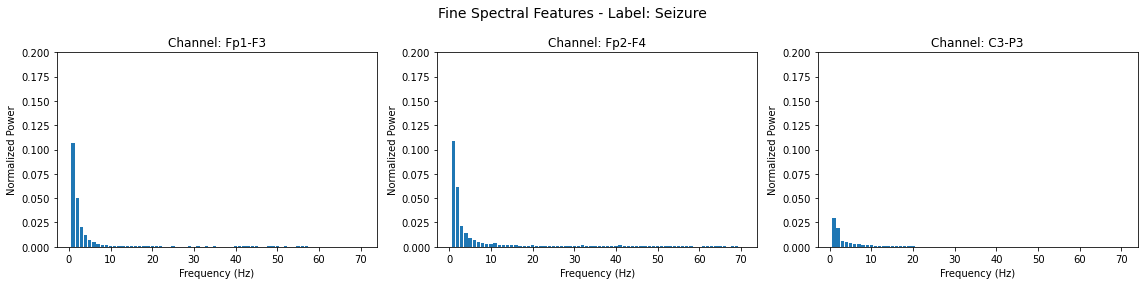

In [38]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
from wettbewerb import get_3montages

# === Load EEG Data ===
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s001_t000.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s001_t000'].iloc[0]['label']

# === Get Montage Data ===
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T  # (time, 3)

# === Filtering ===
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(4, [lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, fs, freq=60.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered = bandpass_filter(montages, fs)
filtered = notch_filter(filtered, fs)

# === Fine-Grained Spectral Features: 1 Hz Bins ===
bins = [(f, f+1) for f in range(1, 71)]  # 1–2 Hz to 70–71 Hz
features = []

for ch in range(filtered.shape[1]):
    f, Pxx = welch(filtered[:, ch], fs=fs, nperseg=512)
    
    bin_powers = []
    for low, high in bins:
        idx = np.logical_and(f >= low, f < high)
        power = np.trapz(Pxx[idx], f[idx]) if np.any(idx) else 0.0
        bin_powers.append(power)
    
    # Optional: normalize power spectrum per channel
    bin_powers = np.array(bin_powers)
    bin_powers /= np.sum(bin_powers) + 1e-9  # Avoid division by zero
    features.append(bin_powers)

# Combine all channels → shape (210,)
features_flat = np.concatenate(features)
print("Feature vector shape:", features_flat.shape)

# === Plot Power Spectra per Channel ===
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    axs[i].bar(range(1, 71), features[i])
    axs[i].set_title(f"Channel: {montage_names[i]}")
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Normalized Power")
    axs[i].set_ylim(0, 0.2)
plt.suptitle(f"Fine Spectral Features - Label: {'Seizure' if label==1 else 'Non-Seizure'}", fontsize=14)
plt.tight_layout()
plt.show()


Feature vector shape: (210,)


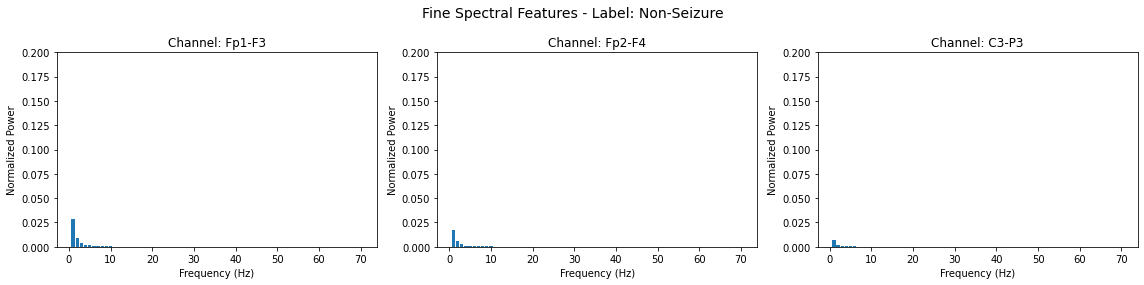

In [39]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, welch
from wettbewerb import get_3montages

# === Load EEG Data ===
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s004_t002.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]
ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s004_t002'].iloc[0]['label']

# === Get Montage Data ===
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T  # (time, 3)

# === Filtering ===
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(4, [lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, fs, freq=60.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered = bandpass_filter(montages, fs)
filtered = notch_filter(filtered, fs)

# === Fine-Grained Spectral Features: 1 Hz Bins ===
bins = [(f, f+1) for f in range(1, 71)]  # 1–2 Hz to 70–71 Hz
features = []

for ch in range(filtered.shape[1]):
    f, Pxx = welch(filtered[:, ch], fs=fs, nperseg=512)
    
    bin_powers = []
    for low, high in bins:
        idx = np.logical_and(f >= low, f < high)
        power = np.trapz(Pxx[idx], f[idx]) if np.any(idx) else 0.0
        bin_powers.append(power)
    
    # Optional: normalize power spectrum per channel
    bin_powers = np.array(bin_powers)
    bin_powers /= np.sum(bin_powers) + 1e-9  # Avoid division by zero
    features.append(bin_powers)

# Combine all channels → shape (210,)
features_flat = np.concatenate(features)
print("Feature vector shape:", features_flat.shape)

# === Plot Power Spectra per Channel ===
fig, axs = plt.subplots(1, 3, figsize=(16, 4))
for i in range(3):
    axs[i].bar(range(1, 71), features[i])
    axs[i].set_title(f"Channel: {montage_names[i]}")
    axs[i].set_xlabel("Frequency (Hz)")
    axs[i].set_ylabel("Normalized Power")
    axs[i].set_ylim(0, 0.2)
plt.suptitle(f"Fine Spectral Features - Label: {'Seizure' if label==1 else 'Non-Seizure'}", fontsize=14)
plt.tight_layout()
plt.show()


In [1]:
!pip install ssqueezepy


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 70.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 MB 60.9 MB/s eta 0:00:0000:0100:01


CWT Tensor shape: torch.Size([3, 64, 256])


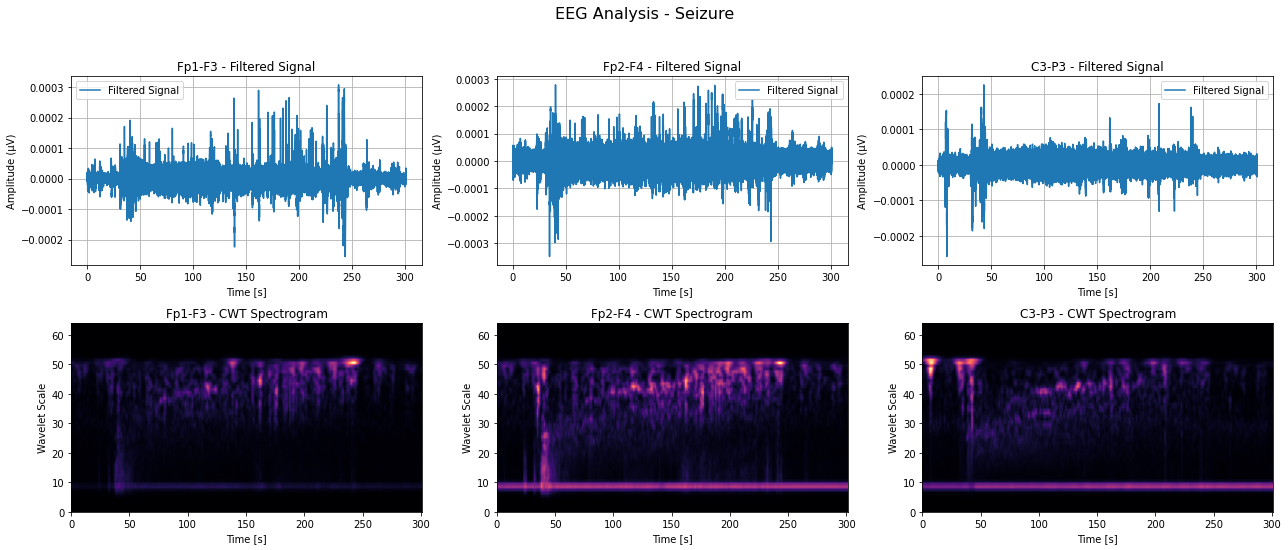

In [8]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from wettbewerb import get_3montages
from ssqueezepy import cwt
from skimage.transform import resize
import torch

# ========== 1. Load EEG ==========
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s001_t000.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]

ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s001_t000'].iloc[0]['label']

# ========== 2. Get 3 Bipolar Montages ==========
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T  # shape: (time, 3)
time = np.arange(montages.shape[0]) / fs  # seconds

# ========== 3. Filtering ==========
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, fs, freq=50.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered = bandpass_filter(montages, fs)
filtered = notch_filter(filtered, fs)

# ========== 4. CWT using ssqueezepy ==========
cwt_images = []
for i in range(3):
    signal = filtered[:, i]
    Wx, scales = cwt(signal, wavelet='morlet', nv=32)
    Wx_mag = np.abs(Wx)

    # Resize to fixed shape for ML input (e.g., 64×256)
    Wx_resized = resize(Wx_mag, (64, 256), mode='reflect', anti_aliasing=True)
    cwt_images.append(Wx_resized)

# Stack and convert to torch tensor
cwt_tensor = torch.tensor(np.stack(cwt_images), dtype=torch.float32)  # shape: (3, 64, 256)
print("CWT Tensor shape:", cwt_tensor.shape)

# ========== 5. Visualization ==========
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

for i in range(3):
    # Row 1: Filtered EEG
    axs[0, i].plot(time, filtered[:, i], label='Filtered Signal')
    axs[0, i].set_title(f"{montage_names[i]} - Filtered Signal")
    axs[0, i].set_xlabel("Time [s]")
    axs[0, i].set_ylabel("Amplitude (µV)")
    axs[0, i].grid()
    axs[0, i].legend()

    # Row 2: CWT Spectrogram
    axs[1, i].imshow(cwt_images[i], aspect='auto', origin='lower', cmap='magma',
                    extent=[0, time[-1], 0, 64])
    axs[1, i].set_title(f"{montage_names[i]} - CWT Spectrogram")
    axs[1, i].set_xlabel("Time [s]")
    axs[1, i].set_ylabel("Wavelet Scale")

plt.suptitle(f"EEG Analysis - {'Seizure' if label==1 else 'Non-Seizure'}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


CWT Tensor shape: torch.Size([3, 64, 256])


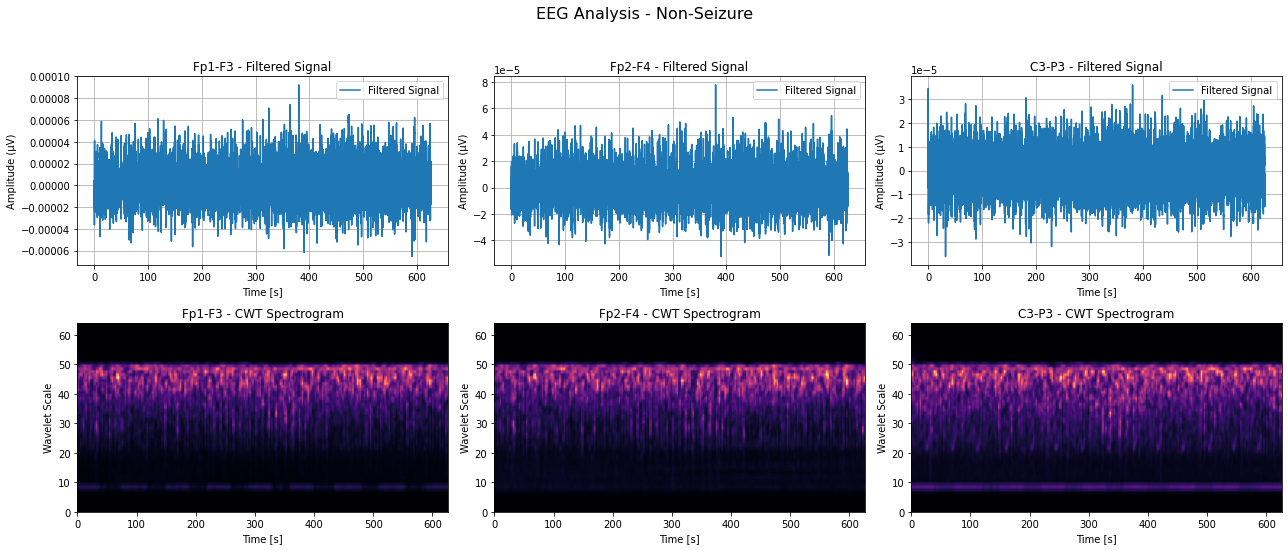

In [7]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from wettbewerb import get_3montages
from ssqueezepy import cwt
from skimage.transform import resize
import torch

# ========== 1. Load EEG ==========
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s004_t002.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]

ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s004_t002'].iloc[0]['label']

# ========== 2. Get 3 Bipolar Montages ==========
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T  # shape: (time, 3)
time = np.arange(montages.shape[0]) / fs  # seconds

# ========== 3. Filtering ==========
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, fs, freq=50.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered = bandpass_filter(montages, fs)
filtered = notch_filter(filtered, fs)

# ========== 4. CWT using ssqueezepy ==========
cwt_images = []
for i in range(3):
    signal = filtered[:, i]
    Wx, scales = cwt(signal, wavelet='morlet', nv=32)
    Wx_mag = np.abs(Wx)

    # Resize to fixed shape for ML input (e.g., 64×256)
    Wx_resized = resize(Wx_mag, (64, 256), mode='reflect', anti_aliasing=True)
    cwt_images.append(Wx_resized)

# Stack and convert to torch tensor
cwt_tensor = torch.tensor(np.stack(cwt_images), dtype=torch.float32)  # shape: (3, 64, 256)
print("CWT Tensor shape:", cwt_tensor.shape)

# ========== 5. Visualization ==========
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

for i in range(3):
    # Row 1: Filtered EEG
    axs[0, i].plot(time, filtered[:, i], label='Filtered Signal')
    axs[0, i].set_title(f"{montage_names[i]} - Filtered Signal")
    axs[0, i].set_xlabel("Time [s]")
    axs[0, i].set_ylabel("Amplitude (µV)")
    axs[0, i].grid()
    axs[0, i].legend()

    # Row 2: CWT Spectrogram
    axs[1, i].imshow(cwt_images[i], aspect='auto', origin='lower', cmap='magma',
                    extent=[0, time[-1], 0, 64])
    axs[1, i].set_title(f"{montage_names[i]} - CWT Spectrogram")
    axs[1, i].set_xlabel("Time [s]")
    axs[1, i].set_ylabel("Wavelet Scale")

plt.suptitle(f"EEG Analysis - {'Seizure' if label==1 else 'Non-Seizure'}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Scattering Tensor shape: torch.Size([3, 126, 2048])


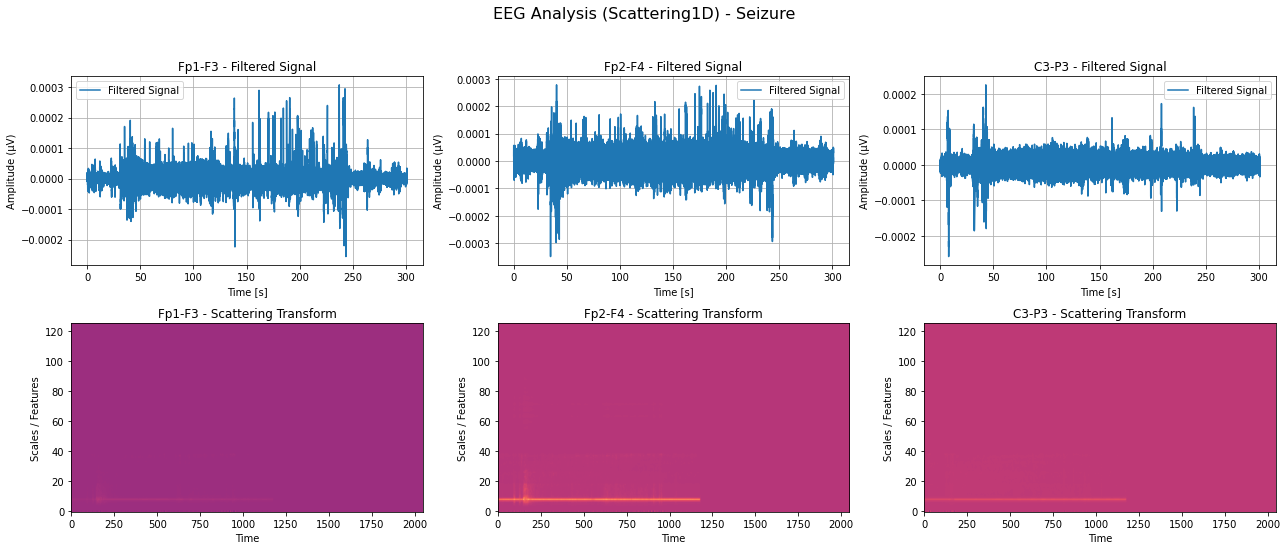

In [12]:
import numpy as np
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from wettbewerb import get_3montages
from kymatio.torch import Scattering1D
import torch

# ========== 1. Load EEG ==========
mat = scipy.io.loadmat("shared_data/training_mini/aaaaaaac_s001_t000.mat")
data = mat['data']
fs = int(mat['fs'].squeeze())
channels = [ch.strip() for ch in mat['channels']]

ref_df = pd.read_csv("shared_data/training_mini/REFERENCE.csv", header=None)
ref_df.columns = ['filename', 'label', 'onset', 'offset']
label = ref_df[ref_df['filename'] == 'aaaaaaac_s001_t000'].iloc[0]['label']

# ========== 2. Get 3 Bipolar Montages ==========
montage_names, montage_data, missing = get_3montages(channels, data)
montages = montage_data.T  # shape: (time, 3)
time = np.arange(montages.shape[0]) / fs  # seconds

# ========== 3. Filtering ==========
def bandpass_filter(signal, fs, lowcut=0.5, highcut=70.0):
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='bandpass', fs=fs)
    return filtfilt(b, a, signal, axis=0)

def notch_filter(signal, fs, freq=50.0, Q=35.0):
    b, a = iirnotch(freq, Q, fs)
    return filtfilt(b, a, signal, axis=0)

filtered = bandpass_filter(montages, fs)
filtered = notch_filter(filtered, fs)

# ========== 4. Scattering1D using Kymatio ==========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper to get next power of 2
def next_power_of_2(x):
    return 1 << (x - 1).bit_length()

# Get padded length
original_len = filtered.shape[0]
padded_len = next_power_of_2(original_len)

# Create scattering object for full padded signal
scattering = Scattering1D(J=6, shape=padded_len, Q=8).to(device)

scat_images = []
for i in range(3):
    signal = filtered[:, i]
    padded = np.pad(signal, (0, padded_len - original_len), mode='constant')
    x_tensor = torch.tensor(padded, dtype=torch.float32, device=device).unsqueeze(0)
    Sx = scattering(x_tensor)  # shape: (1, C, T')
    scat_images.append(Sx.squeeze(0).cpu().numpy())  # shape: (C, T')

# Stack and convert to torch tensor
scattering_tensor = torch.tensor(np.stack(scat_images), dtype=torch.float32)  # shape: (3, C, T')
print("Scattering Tensor shape:", scattering_tensor.shape)

# ========== 5. Visualization ==========
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

for i in range(3):
    # Row 1: Filtered EEG
    axs[0, i].plot(time, filtered[:, i], label='Filtered Signal')
    axs[0, i].set_title(f"{montage_names[i]} - Filtered Signal")
    axs[0, i].set_xlabel("Time [s]")
    axs[0, i].set_ylabel("Amplitude (µV)")
    axs[0, i].grid()
    axs[0, i].legend()

    # Row 2: Scattering Transform
    axs[1, i].imshow(scat_images[i], aspect='auto', origin='lower', cmap='magma')
    axs[1, i].set_title(f"{montage_names[i]} - Scattering Transform")
    axs[1, i].set_xlabel("Time")
    axs[1, i].set_ylabel("Scales / Features")

plt.suptitle(f"EEG Analysis (Scattering1D) - {'Seizure' if label==1 else 'Non-Seizure'}", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
!pip install kymatio

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 KB 5.5 MB/s eta 0:00:00
